<a href="https://colab.research.google.com/github/TamarSdeChen/Self-Learner-DeepLearning-Course-Technion/blob/main/ResNet-18_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import time
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from torchvision.datasets import STL10
from torchvision import transforms, utils, models
from torchvision.transforms import ToTensor


transform_train = transforms.Compose([
    transforms.RandomResizedCrop(96),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(), # uint8 values in [0, 255] -> float tensor with vlaues [0, 1]
])

TRAIN_DATASET = STL10(root="data", split="train", download=True, transform=transform_train)
TEST_DATASET = STL10(root="data", split="test", download=True, transform=ToTensor())

# SPLIT THE TEST TO VALIDATION 0.2 AND TEST 0.8


train_loader = torch.utils.data.DataLoader(TRAIN_DATASET, batch_size=128, shuffle=True, num_workers=2)
#val_loader = torch.utils.data.DataLoader(TEST_DATASET, batch_size=128,sampler=np.arange(2000), num_workers=2)
tset_loader = torch.utils.data.DataLoader(TEST_DATASET, batch_size=128,  shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [43]:
print(len(tset_loader.sampler))

8000


In [44]:
# conect to google drive
from google.colab import drive
drive.mount('/content/drive')

# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
# function to calcualte accuracy of the model
import numpy as np
def calculate_accuracy(model, dataloader, device):
    model.eval() # put in evaluation mode,  turn of DropOut, BatchNorm uses learned statistics
    total_correct = 0
    total_images = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    model_accuracy = total_correct / total_images * 100
    return model_accuracy

In [46]:
model =  models.resnet18().to(device)

In [47]:
from torch import nn
class Dc_model(nn.Module):
    def __init__(self):
        super(Dc_model, self).__init__()
        self.fc_1 = nn.Linear(512, 128)
        self.fc_2 = nn.Linear(128,10)
        self.ReLU = nn.ReLU()
        self.init_weights()

    def init_weights(self):
      for m in self.modules():
        if isinstance(m, nn.Linear):
          torch.nn.init.xavier_normal_(m.weight, gain=1.0)
          if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

    def forward(self,x):
        x = self.ReLU(self.fc_1(x))
        x = self.fc_2(x)
        return x

In [48]:
model_ = Dc_model().to(device)

In [49]:
model.fc = model_

In [50]:
for param in model.parameters():
        param.requires_grad = True
for param in model.fc.parameters():
        param.requires_grad = True

In [51]:
# hyper parameter
batch_size = 256
learning_rate = 1e-3
epochs = 200

# loss criterion
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[120, 130], gamma=0.1)


In [52]:
# training loop
epoch_losses = []
acc_train_list = []
avg_loss_list = []
for epoch in range(1, epochs + 1):
    model.train()  # put in training mode, turn on DropOut, BatchNorm uses batch's statistics
    running_loss = 0.0
    epoch_time = time.time()
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        # send them to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)  # forward pass
        loss = criterion(outputs, labels.to(torch.int64))  # calculate the loss

        # always the same 3 steps
        optimizer.zero_grad()  # zero the parameter gradients
        loss.backward()  # backpropagation
        optimizer.step()  # update parameters

        # print statistics
        running_loss += loss.data.item()

    scheduler.step()
    # Normalizing the loss by the total number of train batches
    avg_loss = running_loss / len(train_loader)
    avg_loss_list.append(avg_loss)

    log = "Epoch: {} | Loss: {:.4f} ".format(epoch, avg_loss)
    print(log)
    if epoch % 50 == 0:
      #val_accuracy = calculate_accuracy(model, val_loader, device)
      #print('validation accuracy')
      #print_acc = "validation accuracy: {} ".format(val_accuracy)
      #print(print_acc)

      print('==> Saving model ...')
      state = {
      'net': model.state_dict(),
      }

      torch.save(state, '/content/drive/MyDrive/DL_project/resnet18_epoch_{}.pth')
print('==> Finished Training ...')

Epoch: 1 | Loss: 2.0166 
Epoch: 2 | Loss: 1.7791 
Epoch: 3 | Loss: 1.7276 
Epoch: 4 | Loss: 1.6883 
Epoch: 5 | Loss: 1.6402 
Epoch: 6 | Loss: 1.6333 
Epoch: 7 | Loss: 1.5433 
Epoch: 8 | Loss: 1.5091 
Epoch: 9 | Loss: 1.4776 
Epoch: 10 | Loss: 1.4968 
Epoch: 11 | Loss: 1.4111 
Epoch: 12 | Loss: 1.3809 
Epoch: 13 | Loss: 1.3750 
Epoch: 14 | Loss: 1.4054 
Epoch: 15 | Loss: 1.3132 
Epoch: 16 | Loss: 1.3405 
Epoch: 17 | Loss: 1.4153 
Epoch: 18 | Loss: 1.3622 
Epoch: 19 | Loss: 1.2817 
Epoch: 20 | Loss: 1.2866 
Epoch: 21 | Loss: 1.2445 
Epoch: 22 | Loss: 1.2490 
Epoch: 23 | Loss: 1.1715 
Epoch: 24 | Loss: 1.1675 
Epoch: 25 | Loss: 1.1437 
Epoch: 26 | Loss: 1.1315 
Epoch: 27 | Loss: 1.1065 
Epoch: 28 | Loss: 1.1352 
Epoch: 29 | Loss: 1.1076 
Epoch: 30 | Loss: 1.1013 
Epoch: 31 | Loss: 1.1116 
Epoch: 32 | Loss: 1.0622 
Epoch: 33 | Loss: 1.0867 
Epoch: 34 | Loss: 1.1078 
Epoch: 35 | Loss: 1.0787 
Epoch: 36 | Loss: 1.0492 
Epoch: 37 | Loss: 1.0639 
Epoch: 38 | Loss: 1.0073 
Epoch: 39 | Loss: 1.0

In [53]:
test_accuracy = calculate_accuracy(model, tset_loader, device)
print(f"final test accuracy: {test_accuracy}")

final test accuracy: 76.9875


[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<function matplotlib.pyplot.show(close=None, block=None)>

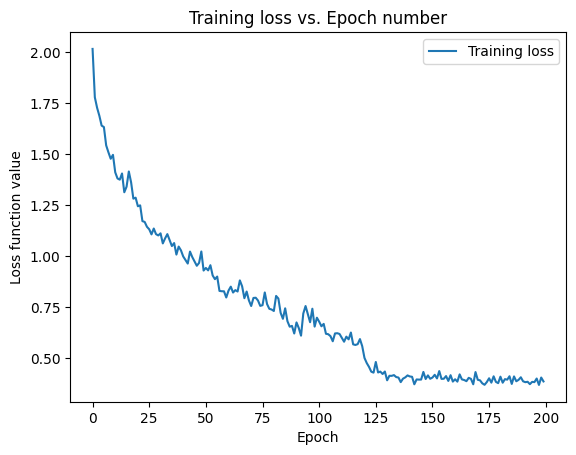

In [54]:

from matplotlib import pyplot as plt
import numpy as np
from google.colab import files

epoch_num = np.arange(0, 200, 1, dtype=int)

plt.plot(epoch_num, torch.as_tensor(avg_loss_list).cpu(), label='Training loss')
plt.ylabel('Loss function value')
plt.xlabel('Epoch')
plt.title('Training loss vs. Epoch number')
plt.legend()
plt.savefig("Training loss.png")

files.download("Training loss.png")
plt.show

In [55]:
print('==> Saving model ...')
state = {
'net': model.state_dict(),
}

torch.save(state, '/content/drive/MyDrive/DL_project/best_resnet18_epoch_200.pth')


==> Saving model ...
